In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import collections
import os
from feature_extraction import extract_features_from_file_list
from config import feature_extraction_params
from find_cars import find_cars
import random
import pickle

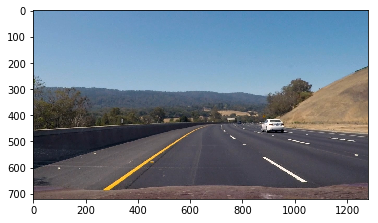

In [6]:
sample_images_dir = 'test_images'
sample_images = [mpimg.imread(p) for p in glob.glob(os.path.join('../', sample_images_dir, '*.jpg'))]
sample_images_features = extract_features_from_file_list(sample_images, feature_extraction_params)
plt.imshow(sample_images[random.randint(0, len(sample_images)-1)])
plt.show()

In [11]:
def compute_heatmap_from_detections(frame, hot_windows, threshold=5, verbose=False, save=False):
    h, w, c = frame.shape
    
    heatmap = np.zeros(shape=(h, w), dtype=np.uint8)
    
    for bbox in hot_windows:
        x_min, y_min = bbox[0]
        x_max, y_max = bbox[1]
        heatmap[y_min:y_max, x_min:x_max] += 1
    
    _, heatmap_thresh = cv2.threshold(heatmap, threshold, 255, type=cv2.THRESH_BINARY)
    heatmap_thresh = cv2.morphologyEx(heatmap_thresh, op=cv2.MORPH_CLOSE, 
                                      kernel=cv2.getStructuringElement(
                                          cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    
    if verbose:
        f, ax = plt.subplots(1, 3)
        ax[0].imshow(frame)
        ax[1].imshow(heatmap, cmap='hot')
        ax[2].imshow(heatmap_thresh, cmap='hot')
        if save:
            plt.savefig(os.path.join('output_image', 'heatmap.jpg'))
        plt.show()
        
    return heatmap, heatmap_thresh

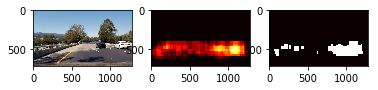

In [12]:
svc = pickle.load(open('weights/svc_car.pickle', 'rb'))
feature_scaler = pickle.load(open('weights/feature_scaler.pickle', 'rb'))

frame = sample_images[0]
ystart = 400
ystop = 656

hot_windows = []

timewindow = 5
hot_windows_history = collections.deque(maxlen=timewindow)

for subsample in np.arange(1, 3, 0.5):
    hot_windows += find_cars(frame, ystart, ystop, subsample,
                             svc, feature_scaler, feature_extraction_params, verbose=False)

keepState = True

if keepState:
    if hot_windows:
        hot_windows_history.append(hot_windows)
        hot_windows = np.concatenate(hot_windows_history)

# compute the heatmap? what's the heatmap means?
threshold = (timewindow-1) if keepState else 0
heatmap, heatmap_thresh = compute_heatmap_from_detections(frame, hot_windows, threshold=threshold, verbose=True, save=True)